## **CNN от LeNet до ResNet**
### Импорты

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

### Устройство

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


### Данные: MNIST

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean/std for MNIST
])

train_dataset = datasets.MNIST('./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print(f"\nTrain: {len(train_dataset)} | Test: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")  # (1, 28, 28)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


Train: 60000 | Test: 10000
Image shape: torch.Size([1, 28, 28])


### Визуализация данных

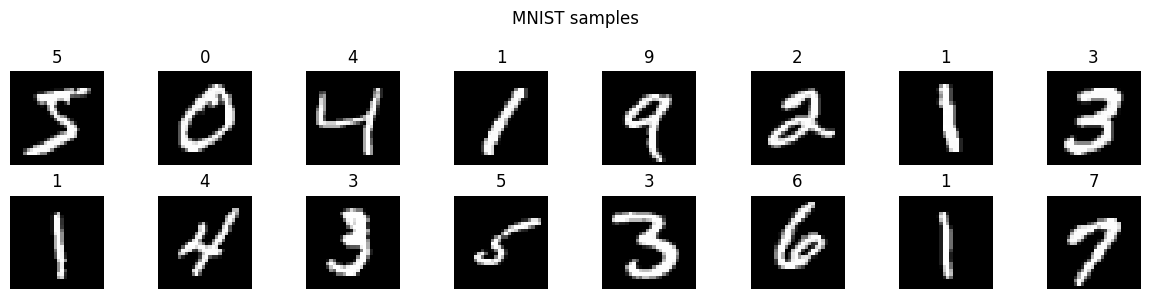

In [4]:
fig, axes = plt.subplots(2, 8, figsize=(12, 3))

for i, ax in enumerate(axes.flatten()):
    img, label = train_dataset[i]

    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(str(label))
    ax.axis('off')

plt.suptitle("MNIST samples")
plt.tight_layout()
plt.show()

## **LeNet-5 (1998)**

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # Свёрточные слои
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)   # 1 -> 6 каналов
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)             # 6 -> 16 каналов

        # Полносвязные слои
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.AvgPool2d(2, 2)


    def forward(self, x):
        # x: (B, 1, 28, 28)
        x = torch.tanh(self.conv1(x))  # -> (B, 6, 28, 28)
        x = self.pool(x)               # -> (B, 6, 14, 14)
        x = torch.tanh(self.conv2(x))  # -> (B, 16, 10, 10)
        x = self.pool(x)               # -> (B, 16, 5, 5)
        x = x.flatten(1)               # -> (B, 400)
        x = torch.tanh(self.fc1(x))    # -> (B, 120)
        x = torch.tanh(self.fc2(x))    # -> (B, 84)
        x = self.fc3(x)                # -> (B, 10)

        return x

## **Modern CNN (AlexNet-style, адаптирован для MNIST)**

In [6]:
class ModernCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (B, 32, 28, 28)
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (B, 64, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # (B, 64, 14, 14)
            nn.Dropout2d(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# (B, 128, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # (B, 128, 7, 7)
            nn.Dropout2d(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )


    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)

        return x

## **ResNet Block + Mini ResNet**

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(),

            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
        )

        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.block(x) + x)  # вот она! Магия ResNet


class MiniResNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.layer1 = ResidualBlock(32)

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.layer3 = ResidualBlock(64)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # (B, 64, 1, 1) независимо от размера входа
            nn.Flatten(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.head(x)
        return x

## **Training and Evaluation**

In [8]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        correct += (logits.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        total_loss += loss.item() * X.size(0)
        correct += (logits.argmax(1) == y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def train_model(model, epochs=5, lr=1e-3):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    for epoch in range(epochs):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
        te_loss, te_acc = evaluate(model, test_loader, criterion)

        history['train_loss'].append(tr_loss)
        history['test_loss'].append(te_loss)

        history['train_acc'].append(tr_acc)
        history['test_acc'].append(te_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train loss: {tr_loss:.4f} acc: {tr_acc:.4f} | "
              f"Test loss: {te_loss:.4f} acc: {te_acc:.4f}")

    return history

## **Обучаем все три модели**

In [9]:
print("="*50)
print("LeNet-5")
print("="*50)
lenet = LeNet5()
print(f"Параметров: {sum(p.numel() for p in lenet.parameters()):,}")
h_lenet = train_model(lenet, epochs=5)

print("\n" + "="*50)
print("Modern CNN")
print("="*50)
modern = ModernCNN()
print(f"Параметров: {sum(p.numel() for p in modern.parameters()):,}")
h_modern = train_model(modern, epochs=5)

print("\n" + "="*50)
print("MiniResNet")
print("="*50)
resnet = MiniResNet()
print(f"Параметров: {sum(p.numel() for p in resnet.parameters()):,}")
h_resnet = train_model(resnet, epochs=5)

LeNet-5
Параметров: 61,706
Epoch 1/5 | Train loss: 0.2424 acc: 0.9315 | Test loss: 0.0819 acc: 0.9756
Epoch 2/5 | Train loss: 0.0754 acc: 0.9766 | Test loss: 0.0581 acc: 0.9819
Epoch 3/5 | Train loss: 0.0529 acc: 0.9833 | Test loss: 0.0585 acc: 0.9817
Epoch 4/5 | Train loss: 0.0428 acc: 0.9870 | Test loss: 0.0482 acc: 0.9842
Epoch 5/5 | Train loss: 0.0336 acc: 0.9894 | Test loss: 0.0443 acc: 0.9858

Modern CNN
Параметров: 1,701,130
Epoch 1/5 | Train loss: 0.1743 acc: 0.9476 | Test loss: 0.0367 acc: 0.9885
Epoch 2/5 | Train loss: 0.0657 acc: 0.9805 | Test loss: 0.0257 acc: 0.9908
Epoch 3/5 | Train loss: 0.0499 acc: 0.9849 | Test loss: 0.0220 acc: 0.9929
Epoch 4/5 | Train loss: 0.0438 acc: 0.9868 | Test loss: 0.0208 acc: 0.9931
Epoch 5/5 | Train loss: 0.0364 acc: 0.9885 | Test loss: 0.0205 acc: 0.9929

MiniResNet
Параметров: 112,106
Epoch 1/5 | Train loss: 0.2851 acc: 0.9472 | Test loss: 0.1573 acc: 0.9583
Epoch 2/5 | Train loss: 0.0575 acc: 0.9857 | Test loss: 0.0769 acc: 0.9778
Epoch 3

### Визуализация: сравнение моделей

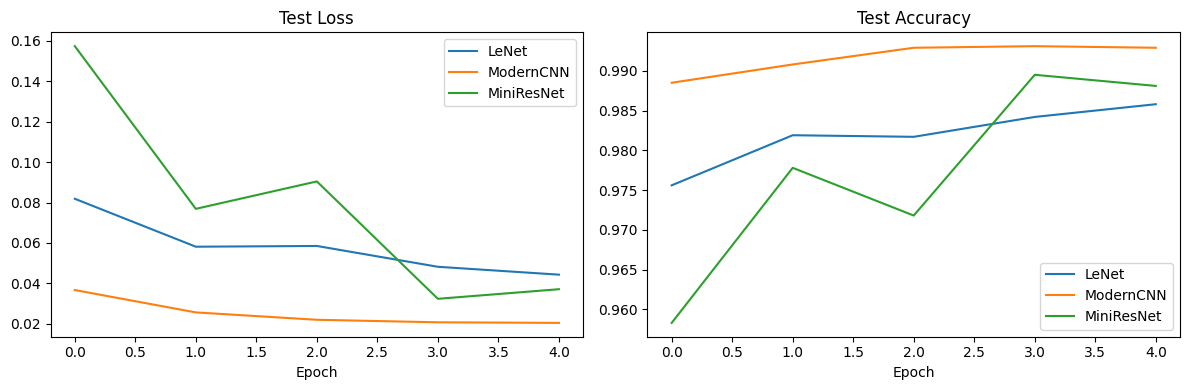

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for h, name in [(h_lenet, 'LeNet'), (h_modern, 'ModernCNN'), (h_resnet, 'MiniResNet')]:
    axes[0].plot(h['test_loss'], label=name)
    axes[1].plot(h['test_acc'], label=name)

axes[0].set_title("Test Loss"); axes[0].set_xlabel("Epoch"); axes[0].legend()
axes[1].set_title("Test Accuracy"); axes[1].set_xlabel("Epoch"); axes[1].legend()

plt.tight_layout()
plt.show()

### Визуализация фильтров LeNet

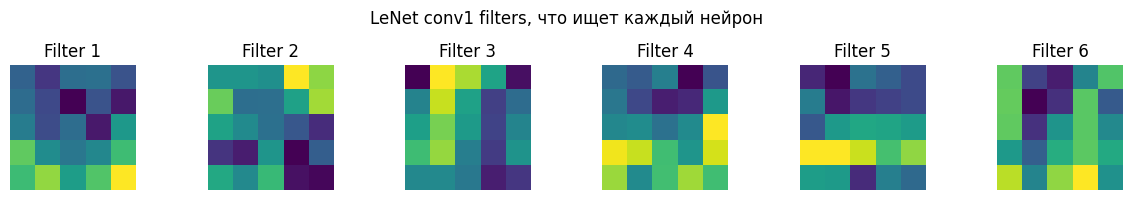

In [11]:
filters = lenet.conv1.weight.data.cpu()  # (6, 1, 5, 5)
fig, axes = plt.subplots(1, 6, figsize=(12, 2))

for i, ax in enumerate(axes):
    ax.imshow(filters[i, 0], cmap='viridis')
    ax.set_title(f"Filter {i+1}")
    ax.axis('off')

plt.suptitle("LeNet conv1 filters, что ищет каждый нейрон")
plt.tight_layout()
plt.show()

### Визуализация feature maps

Что видит сеть внутри:


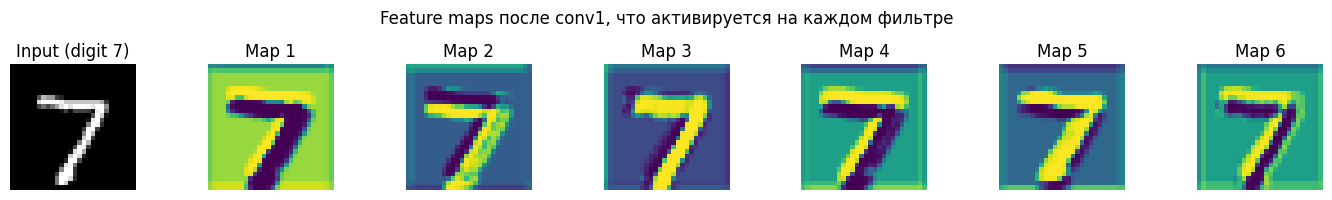

In [12]:
print("Что видит сеть внутри:")
img, label = test_dataset[0]
img_tensor = img.unsqueeze(0).to(device)  # (1, 1, 28, 28)

lenet.eval()

with torch.no_grad():
    feat_map = torch.tanh(lenet.conv1(img_tensor))  # (1, 6, 28, 28)

fig, axes = plt.subplots(1, 7, figsize=(14, 2))

axes[0].imshow(img.squeeze(), cmap='gray')
axes[0].set_title(f"Input (digit {label})")
axes[0].axis('off')

for i in range(6):
    axes[i+1].imshow(feat_map[0, i].cpu())
    axes[i+1].set_title(f"Map {i+1}")
    axes[i+1].axis('off')

plt.suptitle("Feature maps после conv1, что активируется на каждом фильтре")
plt.tight_layout()
plt.show()